# Multimedia Information Retrieval

The main objective for this project is to develop an information retrieval system, using some concepts seen in Multimedia classes, such as a dictionary of visual words and local feature extraction. Given an image, we should return the most similar images from the dataset.

It might be necessary to uncomment the code below and run it once before running the notebook.

In [12]:
## Run this before running the notebook
#!apt update && apt install -y python3-opencv
#!pip install -r requirements.txt

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

# Dataset Preprocessing

The dataset we used (https://www.csc.kth.se/~heydarma/Datasets.html) has images from animals and a mask, representing the foreground of the images. Here, we are using this mask to delimit a blur, so the background will not affect so much the final result.

In [14]:
# Apply blurring and dark the background on the image {directory}/original/{filename}.jpg
# according to the segment mask at {directory}/segment/{filename}.png
def preprocess(directory, filename):
    img = cv2.imread(f"{directory}/original/{filename}.jpg")
    seg = cv2.imread(f"{directory}/segment/{filename}.png")

    blurred = cv2.blur(img, (25, 25))
    black = np.zeros_like(img)
    blurred = 0.3 * blurred + 0.7 * black
    out = np.where(seg == np.array([1, 1, 1]), img, blurred)

    out_dir = 'preprocessed'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # save the image
    cv2.imwrite(f'{out_dir}/{filename}.jpg', out)

# Apply this preprocessing for each animal on the dataset
for animal in os.listdir('dataset'):
    for img in os.listdir(f'dataset/{animal}/original'):
        
        filename = img.split('.')
        if len(filename[0]) > 0:
            preprocess(f'dataset/{animal}', filename[0])

# Extract local features

Now we extract the local features of each image and create the Bag of Features.

In [15]:
# Extract the keypoints and descriptors of given image using SIFT
def extract_descriptors(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)

    return keypoints, descriptors

# Read the image and return the descriptors, ignoring the keypoints
def process(filename):
    img = cv2.imread(filename)
    keypoints, descriptors = extract_descriptors(img)
    return descriptors

# Process each image of the dataset
filenames = [f'preprocessed/{filename}' for filename in os.listdir('preprocessed')]

# Create the bag of features containing every features from the dataset
bag_features = []
for f_img in filenames:
    bag_features = bag_features + process(f_img).tolist()

# Create dictionary of descriptors

With the bag of features, we can cluster them into some groups. The centroids of each group will create the bag of visual words (BoVW).

In [16]:
# Create the dictionary of visual words of dict_size using kmeans 
def create_dict(bag, dict_size):
    bag = np.array(bag, dtype=np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(bag, dict_size, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # return a list of centroids
    return center

# Here we fix the dictionary size
dict_size = 80

# Create the bag of visual words
bovw = create_dict(bag_features, dict_size)

# Create histograms for dataset

With the BoVW created, we can create the histograms of visual words for each image, that will represent the image.

In [17]:
# returns the euclidean distance between objects pt1 and pt2
def euclidean_distance(pt1, pt2):
    return cv2.norm(np.float32(pt1), np.float32(pt2), cv2.NORM_L2)

# returns the features histogram for a given file
#  - extract the descriptors and compare them to the bovw
def create_histogram(filename):
    des = process(filename)
    score = np.zeros(len(bovw)).astype(np.float32)

    for d in des:
        best = 0
        for j in range(len(bovw)):
            if euclidean_distance(d, bovw[j]) < euclidean_distance(d, bovw[best]):
                best = j
        score[best] += 1
    return score

# create a histogram for each file
histograms = [create_histogram(f) for f in filenames]

# Single input image comparison

Finally, we can create the histogram for another image, and compare it with the dataset created.

In [26]:
# compare two histograms, finding their distance using Chi-Square
def compare_histograms(h1, h2):
    return cv2.compareHist(h1, h2, cv2.HISTCMP_CHISQR)

# path to input image
filename = "preprocessed/giraffe_5.jpg"

# extract descriptors and create the feature histogram for the input image
input_desc = process(filename)
input_hist = create_histogram(filename)

# compare this image to the original dataset, and insert the results in this array
results = []
for i in range(len(histograms)):
    dist = compare_histograms(input_hist, histograms[i])
    results.append([filenames[i], dist])

# sort the array according to the distance
results = np.array(results)
results = results[results[:, 1].astype(np.float64).argsort()]

# Output list of similar images

List of the 10 most similar images and plot of the 4 most similar images.

10 most similar images:
preprocessed/giraffe_5.jpg  -> Distance:  0.0
preprocessed/giraffe_17.jpg  -> Distance:  223.66102586145138
preprocessed/deer_3.jpg  -> Distance:  268.2283713528394
preprocessed/giraffe_19.jpg  -> Distance:  275.98396810045745
preprocessed/deer_13.jpg  -> Distance:  278.83033429533424
preprocessed/gorilla_2.jpg  -> Distance:  280.36933140933144
preprocessed/penguim_20.jpg  -> Distance:  285.69960271407086
preprocessed/giraffe_3.jpg  -> Distance:  286.11232901456304
preprocessed/giraffe_2.jpg  -> Distance:  289.0063727958409
preprocessed/wolf_9.jpg  -> Distance:  292.05597643097644


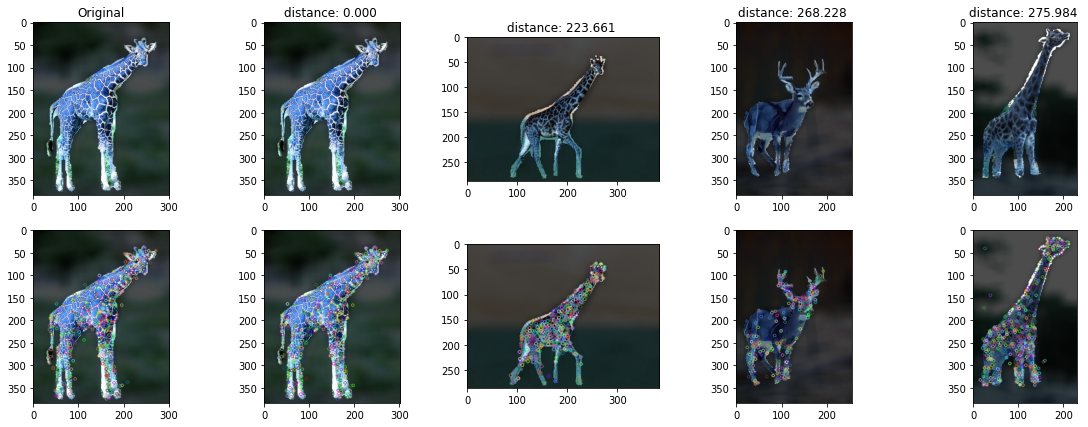

In [27]:
# print a list of 10 most similar images
print('10 most similar images:')
for i in range(10):
    print(results[i, 0], ' -> Distance: ', results[i, 1])

# plot them, and also drawing their keypoints on the bottom line
plt.figure(figsize=(20, 7))

plt.subplot(251)
plt.imshow(cv2.imread(filename))
plt.title('Original')
for i in range(4):
    plt.subplot(2, 5, i + 2)
    plt.imshow(cv2.imread(results[i][0]))
    plt.title('distance: %.3f ' % (float(results[i][1])))

plt.subplot(256)
img = cv2.imread(filename)
keypoints, descriptors = extract_descriptors(img)
plt.imshow(cv2.drawKeypoints(img, keypoints, img.copy()))
for i in range(4):
    plt.subplot(2, 5, i + 7)

    img = cv2.imread(results[i][0])
    keypoints, descriptors = extract_descriptors(img)
    plt.imshow(cv2.drawKeypoints(img, keypoints, img.copy()))

# Efficiency test

Now we utilise the F1 score to classify the accuracy of our program. It conveys a balance between the precision and the recall of the result. In the next cells, we will do the same process, but partitioning beforehand the dataset between training and testing sets.

In [28]:
test = 0.25
np.random.shuffle(filenames)

# Split test and training files
test_sz = round(len(filenames) * test)
testing_files = filenames[:test_sz]
training_files = filenames[test_sz:]

## Simplify each training image into a Histogram of Features

In [29]:
# Generate bag of features, BoVW and Histogram of Features for the training images
bag_features = []
for f_img in training_files:
    bag_features = bag_features + process(f_img).tolist()

dict_size = 80 # magic number
bovw = create_dict(bag_features, dict_size)

histograms = [create_histogram(f) for f in training_files]

## Test and calculate F1 Score

As this is not a binary classification, we calculate F1 score for each of the classes, and get the average of all of them.
The F1 score is the harmonic mean between recall and precision, where precision is the number of true positives over all positives, and recall is the number of true positives over all experiments that should be positive (true positives + false negatives)

In [30]:
true_pos = {} # true_pos[c] = num of true positives of class c
false_pos = {} # false_pos[c] = num of false positives of class c
should_be = {} # should_be[c] = num of false negatives of class c

classes = os.listdir('dataset')

# gets dic[key] or 0 if its not set
def get(dic, key):
    return dic[key] if key in dic else 0

# gets the class prefix of a filename
def get_class(filename):
    return filename.split('_')[0].split('/')[1]

for filename in testing_files:
    input_desc = process(filename)
    input_hist = create_histogram(filename)

    # compare this image to the original dataset, and insert the results in this array
    results = []
    for i in range(len(training_files)):
        dist = compare_histograms(input_hist, histograms[i])
        results.append([training_files[i], dist])
    
    # sort results with increasing distance
    results = np.array(results)
    match = results[results[:, 1].astype(np.float64).argsort()][0][0] # get best match

    print(get_class(filename), get_class(match))
    if get_class(filename) == get_class(match): # true positive
        if get_class(match) in true_pos:
            true_pos[get_class(match)] += 1
        else:
            true_pos[get_class(match)] = 1
    else: # negative
        if get_class(match) in false_pos: # increase false positive count of match
            false_pos[get_class(match)] += 1
        else:
            false_pos[get_class(match)] = 1
        if get_class(filename) in should_be: # increase false negative count of test
            should_be[get_class(filename)] += 1
        else:
            should_be[get_class(filename)] = 1

# Get average F1 score over all classes
sum = 0
tot = 0
for animal in classes:
    tot += 1
    if get(true_pos, animal) == 0:
        print("Warning: no true positive for this class")
        continue
    # calculate precision and recall
    precision = get(true_pos, animal)/(get(true_pos, animal) + get(false_pos, animal))
    recall = get(true_pos, animal)/(get(true_pos, animal) + get(should_be, animal))
    hm = precision * recall / (precision + recall) # get harmonic mean
    sum += hm

print('F1 score:', sum/tot)

wolf wolf
wolf wolf
deer deer
deer deer
gorilla deer
wolf deer
gorilla deer
deer deer
wolf deer
penguim penguim
penguim penguim
wolf penguim
deer deer
deer penguim
gorilla gorilla
gorilla deer
giraffe giraffe
penguim penguim
wolf wolf
deer deer
penguim penguim
penguim penguim
gorilla gorilla
wolf deer
F1 score: 0.35929971988795517


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c49759d8-944a-4cb2-ae9b-3a17004d3b2a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>